<a href="https://colab.research.google.com/github/Kryptera-K/LNT-Laguerre-MACD-Level-Compression-Strategy/blob/main/LNT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.7/527.7 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 35.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import vectorbt as vbt

# -------------------------
# Download Data
# -------------------------

symbol = "LNT"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
df.to_csv("LNT_clean.csv", index=False)
df

/tmp/ipython-input-2969821680.py:15: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
2000-01-03,4.566226,4.683308,4.534294,4.683308,229400
2000-01-04,4.566226,4.587513,4.502362,4.523650,239600
2000-01-05,4.789746,4.832321,4.555580,4.555580,284200
2000-01-06,4.789746,4.853609,4.715239,4.768458,142800
2000-01-07,4.853608,4.874896,4.768457,4.789745,130400
...,...,...,...,...,...
2025-11-17,68.099998,68.300003,67.459999,67.519997,1619700
2025-11-18,68.089996,68.790001,67.839996,68.430000,1999300
2025-11-19,67.220001,68.089996,67.099998,68.019997,1783800


In [ ]:
# -------------------------
# Necessary Parameters
# -------------------------

LRSI_GAMMA = 0.5
LRSI_LEVEL = 0.5
MACD_FAST = 12
MACD_LEVEL = 1.0
MACD_SIGNAL = 9
MACD_SLOW = 26
STOCHASTIC_D_PERIOD = 3
STOCHASTIC_K_PERIOD = 14
WR_LEVEL = -50
WR_PERIOD = 14

# -------------------------
# Indicator Functions
# -------------------------

def macd_lower_level(df, level=MACD_LEVEL):
    df = calculate_macd(df)
    return df["MACD"] < level


def calculate_macd(df, fast=MACD_FAST, slow=MACD_SLOW, signal=MACD_SIGNAL):
    """
    Calculate MACD and Signal lines.
    """
    df = df.copy()
    df["EMA_fast"] = df["Close"].ewm(span=fast, adjust=False).mean()
    df["EMA_slow"] = df["Close"].ewm(span=slow, adjust=False).mean()
    df["MACD"] = df["EMA_fast"] - df["EMA_slow"]
    df["Signal"] = df["MACD"].ewm(span=signal, adjust=False).mean()

    # Previous values for comparisons
    df["MACD_prev"] = df["MACD"].shift(1)
    df["Signal_prev"] = df["Signal"].shift(1)

    return df


def laguerre_rsi_cross_above_level(df, level=LRSI_LEVEL, gamma=LRSI_GAMMA):
    df = df.copy()
    df['LRsi'] = calculate_laguerre_rsi(df['Close'], gamma)
    return (df['LRsi'] > level) & (df['LRsi'].shift(1) <= level)


def calculate_laguerre_rsi(series, gamma=LRSI_GAMMA):
    """
    Calculate Laguerre RSI for a pandas Series of close prices.
    Returns a pandas Series of Laguerre RSI values.
    """
    L0 = L1 = L2 = L3 = 0
    lrsi = []

    for price in series:
        L0 = (1 - gamma) * price + gamma * L0
        L1 = -gamma * L0 + L0 + gamma * L1
        L2 = -gamma * L1 + L1 + gamma * L2
        L3 = -gamma * L2 + L2 + gamma * L3

        CU = max(L0 - L1, 0) + max(L1 - L2, 0) + max(L2 - L3, 0)
        CD = max(L1 - L0, 0) + max(L2 - L1, 0) + max(L3 - L2, 0)

        lrsi.append(CU / (CU + CD) if (CU + CD) != 0 else 0)

    return pd.Series(lrsi, index=series.index)


def slow_d_rising(df):
    df = calculate_stochastic(df)
    return df['Slow_%D'].diff() > 0


def calculate_stochastic(df, k_period=STOCHASTIC_K_PERIOD, d_period=STOCHASTIC_D_PERIOD):
    """Calculate Fast %K and Slow %D"""
    low_min = df['Low'].rolling(window=k_period).min()
    high_max = df['High'].rolling(window=k_period).max()

    df['Fast_%K'] = 100 * (df['Close'] - low_min) / (high_max - low_min)
    df['Slow_%D'] = df['Fast_%K'].rolling(window=d_period).mean()
    return df


def wr_cross_below_level(df, level=WR_LEVEL):
    df = calculate_williams_r(df)
    wr = df['Williams_%R']
    return (wr < level) & (wr.shift(1) >= level)


def calculate_williams_r(df, period=WR_PERIOD):
    highest_high = df['High'].rolling(window=period).max()
    lowest_low = df['Low'].rolling(window=period).min()
    df['Williams_%R'] = -100 * (highest_high - df['Close']) / (highest_high - lowest_low)
    return df



# -------------------------
# Entry conditions
# -------------------------

df["MACD_lower_level"] = macd_lower_level(df)
df["LRsi_Cross_Above_Level"] = laguerre_rsi_cross_above_level(df)

# -------------------------
# Exit conditions
# -------------------------

df["Stochastic_Slow_%D_Rising"] = slow_d_rising(df)
df["WR_Cross_Below_Level"] = wr_cross_below_level(df)

# -------------------------
# Signals
# -------------------------

entry_conditions = [
    'MACD_lower_level',
    'LRsi_Cross_Above_Level',
]
exit_conditions = [
    'Stochastic_Slow_%D_Rising',
    'WR_Cross_Below_Level',
]

df['entry_signal'] = df[entry_conditions].all(axis=1)
df['exit_signal']  = df[exit_conditions].all(axis=1)

# -------------------------
# Backtest
# -------------------------


shift_entries = df['entry_signal'].shift(1).astype(bool).fillna(False).to_numpy()
shift_exits = df['exit_signal'].shift(1).astype(bool).fillna(False).to_numpy()

pf = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=shift_entries,
    exits=shift_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='1d'
)


# -------------------------
# Portfolio Stats / Plot
# -------------------------

print(pf.stats())
pf.plot().show()

Start                                 2000-01-03 00:00:00
End                                   2025-11-21 00:00:00
Period                                 6513 days 00:00:00
Start Value                                      100000.0
End Value                                  2203663.227442
Total Return [%]                              2103.663227
Benchmark Return [%]                          1343.852118
Max Gross Exposure [%]                              100.0
Total Fees Paid                             101255.782181
Max Drawdown [%]                                42.440788
Max Drawdown Duration                  1046 days 00:00:00
Total Trades                                           68
Total Closed Trades                                    67
Total Open Trades                                       1
Open Trade PnL                              221096.873391
Win Rate [%]                                    50.746269
Best Trade [%]                                  82.616251
Worst Trade [%

In [ ]:
# Buy and Hold Performance Metrics
df_holding = df['Open']
pf_holding = vbt.Portfolio.from_holding(df_holding, init_cash=100_000 , freq='D')
print(pf_holding.stats())

Start                         2000-01-03 00:00:00
End                           2025-11-21 00:00:00
Period                         6513 days 00:00:00
Start Value                              100000.0
End Value                          1443852.117514
Total Return [%]                      1343.852118
Benchmark Return [%]                  1343.852118
Max Gross Exposure [%]                      100.0
Total Fees Paid                               0.0
Max Drawdown [%]                        51.776664
Max Drawdown Duration           981 days 00:00:00
Total Trades                                    1
Total Closed Trades                             0
Total Open Trades                               1
Open Trade PnL                     1343852.117514
Win Rate [%]                                  NaN
Best Trade [%]                                NaN
Worst Trade [%]                               NaN
Avg Winning Trade [%]                         NaN
Avg Losing Trade [%]                          NaN


/tmp/ipython-input-2841367774.py:13: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


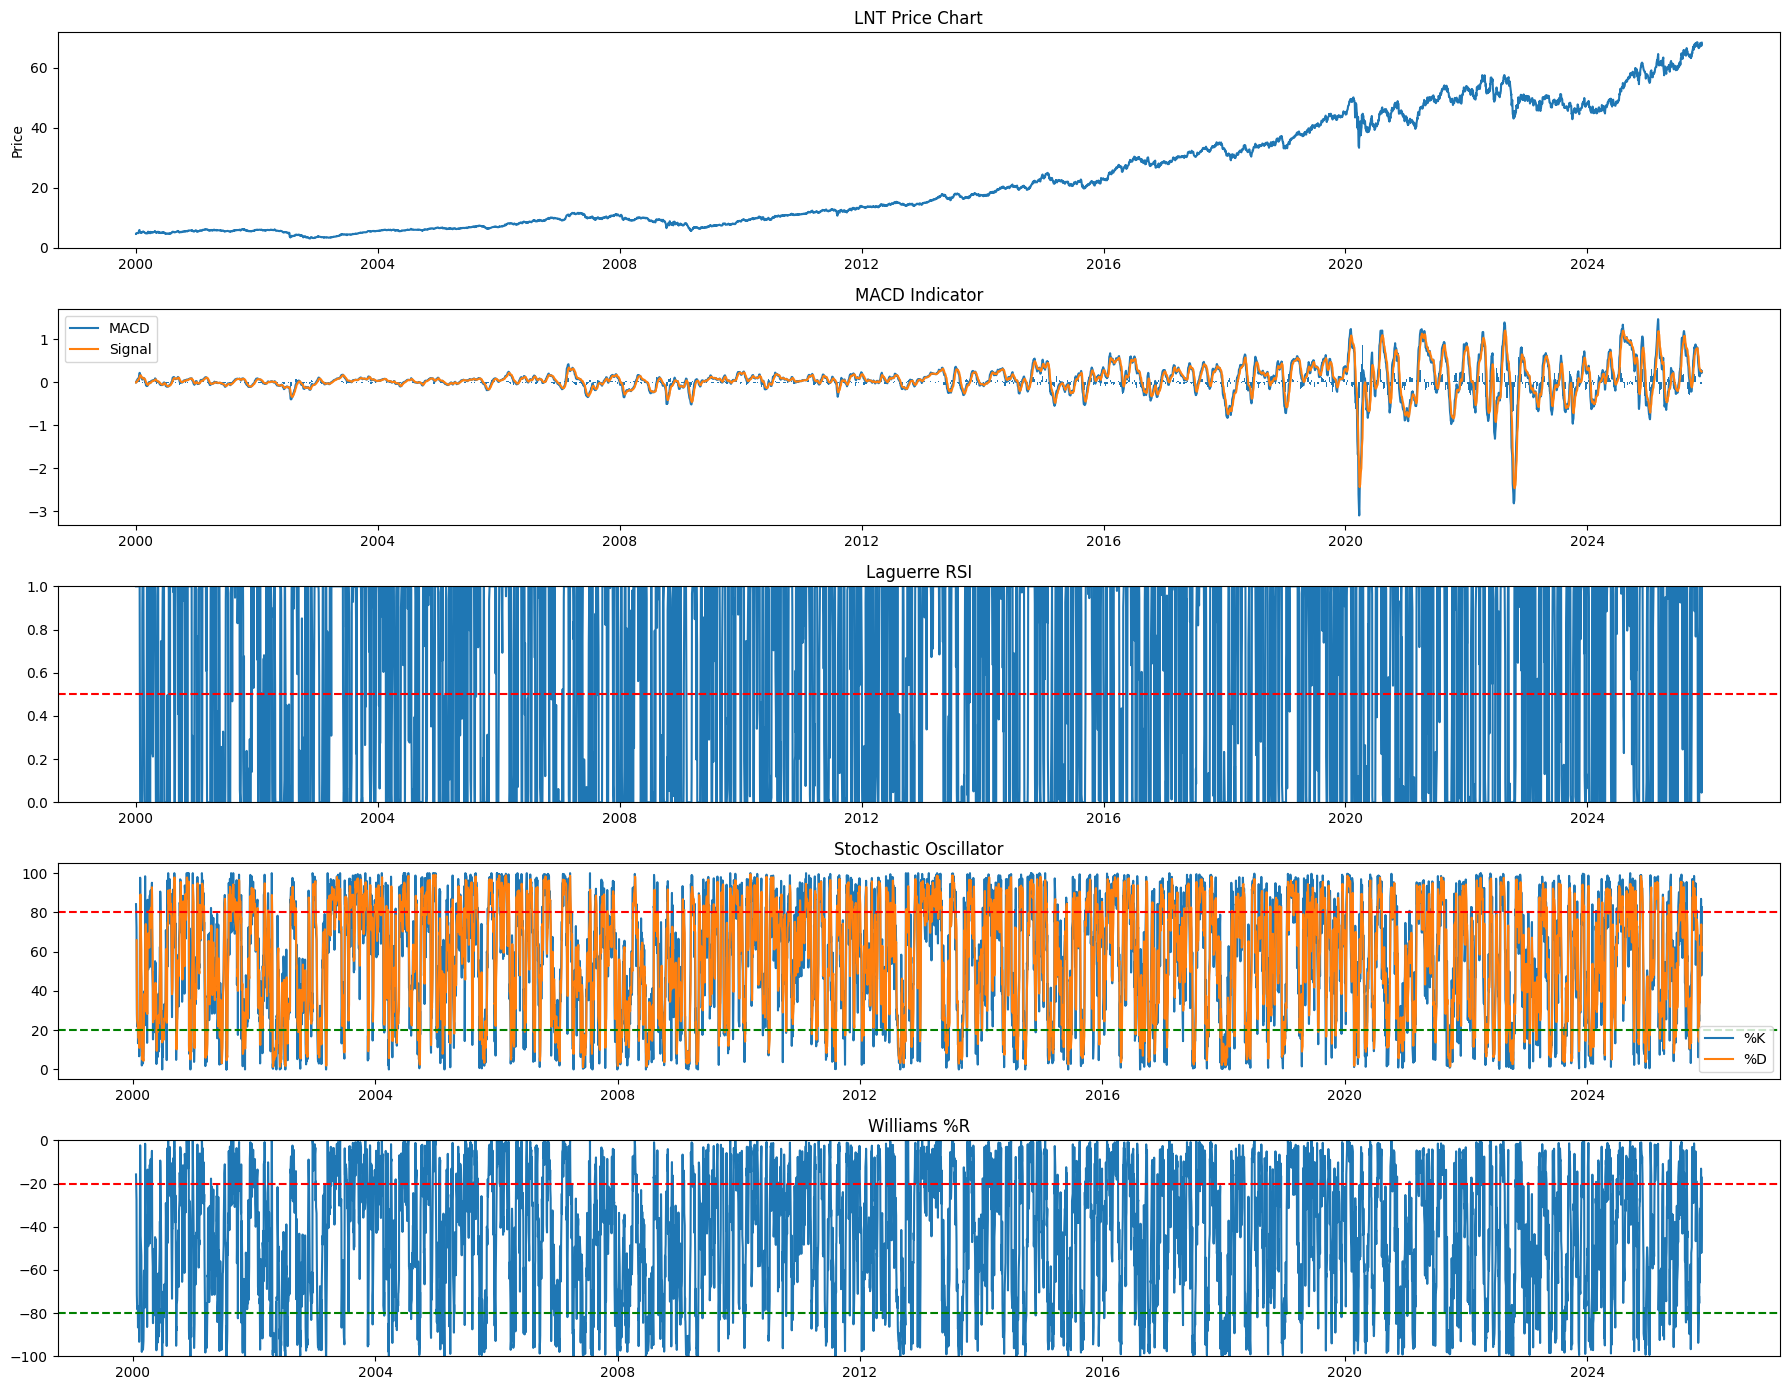

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# ------------------------------------------------
# Download Data
# ------------------------------------------------
symbol = "LNT"
start_date = "2000-01-01"
end_date = "2026-01-01"

df = yf.download(symbol, start=start_date, end=end_date, multi_level_index=False)
df.dropna(inplace=True)

# ------------------------------------------------
# Indicator Parameters
# ------------------------------------------------

LRSI_GAMMA = 0.5
LRSI_LEVEL = 0.5
MACD_FAST = 12
MACD_SLOW = 26
MACD_SIGNAL = 9
STOCH_K_PERIOD = 14
STOCH_D_PERIOD = 3
WR_PERIOD = 14

# ------------------------------------------------
# Indicator Calculations
# ------------------------------------------------

def calculate_macd(df):
    df["EMA_fast"] = df["Close"].ewm(span=MACD_FAST, adjust=False).mean()
    df["EMA_slow"] = df["Close"].ewm(span=MACD_SLOW, adjust=False).mean()
    df["MACD"] = df["EMA_fast"] - df["EMA_slow"]
    df["Signal"] = df["MACD"].ewm(span=MACD_SIGNAL, adjust=False).mean()
    df["Histogram"] = df["MACD"] - df["Signal"]
    return df

def calculate_laguerre_rsi(series, gamma=LRSI_GAMMA):
    L0 = L1 = L2 = L3 = 0
    lrsi = []

    for price in series:
        L0 = (1 - gamma) * price + gamma * L0
        L1 = -gamma * L0 + L0 + gamma * L1
        L2 = -gamma * L1 + L1 + gamma * L2
        L3 = -gamma * L2 + L2 + gamma * L3

        CU = max(L0 - L1, 0) + max(L1 - L2, 0) + max(L2 - L3, 0)
        CD = max(L1 - L0, 0) + max(L2 - L1, 0) + max(L3 - L2, 0)

        lrsi.append(CU / (CU + CD) if (CU + CD) != 0 else 0)

    return pd.Series(lrsi, index=series.index)

def calculate_stochastic(df):
    low_min = df['Low'].rolling(STOCH_K_PERIOD).min()
    high_max = df['High'].rolling(STOCH_K_PERIOD).max()

    df['Fast_%K'] = 100 * (df['Close'] - low_min) / (high_max - low_min)
    df['Slow_%D'] = df['Fast_%K'].rolling(STOCH_D_PERIOD).mean()
    return df

def calculate_williams_r(df):
    highest_high = df['High'].rolling(WR_PERIOD).max()
    lowest_low = df['Low'].rolling(WR_PERIOD).min()
    df['Williams_%R'] = -100 * (highest_high - df['Close']) / (highest_high - lowest_low)
    return df

# Apply Indicators
df = calculate_macd(df)
df["Laguerre_RSI"] = calculate_laguerre_rsi(df["Close"])
df = calculate_stochastic(df)
df = calculate_williams_r(df)

# ------------------------------------------------
# Plotting
# ------------------------------------------------
plt.figure(figsize=(18, 14))

# --- PRICE CHART ---
plt.subplot(5, 1, 1)
plt.plot(df.index, df["Close"])
plt.title("LNT Price Chart")
plt.ylabel("Price")

# --- MACD ---
plt.subplot(5, 1, 2)
plt.plot(df.index, df["MACD"], label="MACD")
plt.plot(df.index, df["Signal"], label="Signal")
plt.bar(df.index, df["Histogram"], width=1)
plt.title("MACD Indicator")
plt.legend()

# --- Laguerre RSI ---
plt.subplot(5, 1, 3)
plt.plot(df.index, df["Laguerre_RSI"])
plt.axhline(0.5, color="red", linestyle="--")
plt.title("Laguerre RSI")
plt.ylim(0, 1)

# --- Stochastic ---
plt.subplot(5, 1, 4)
plt.plot(df.index, df["Fast_%K"], label="%K")
plt.plot(df.index, df["Slow_%D"], label="%D")
plt.axhline(80, color="red", linestyle="--")
plt.axhline(20, color="green", linestyle="--")
plt.title("Stochastic Oscillator")
plt.legend()

# --- Williams %R ---
plt.subplot(5, 1, 5)
plt.plot(df.index, df["Williams_%R"])
plt.axhline(-20, color="red", linestyle="--")
plt.axhline(-80, color="green", linestyle="--")
plt.title("Williams %R")
plt.ylim(-100, 0)

plt.tight_layout()
plt.show()
